In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import regex as re

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [2]:
movies = pd.read_csv('data/cleaned_movie_stats.csv')

# Extracting Labels
ratings_labels = movies['vote_average'].values
popularity_labels =  movies['popularity'].values
movie_label = movies['movie'].values

# Data
movies = movies.drop(['genres', 'vid_ids', 'id', 'homepage','revenue', 
                      'release_date', 'decade', 'original_title', 'production_countries',
                     'production_companies', 'original_language', 'popularity', 'vote_average',
                     'spoken_languages', 'status', 'title', 'keywords', 'vote_count'], axis=1)
movies.head()

,movie,views,likes,dislikes,comments,budget,overview,runtime,tagline,genre,keyword,language,companies,countries,year,month,homepage_binary,budget_mln
0,Avatar,8611952.0,45703.0,2137.0,7631.0,237000000,"In the 22nd century, a paraplegic Marine is di...",162.0,Enter the World of Pandora.,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","['culture clash', 'future', 'space war', 'spac...","['English', 'Español']","['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2009.0,12.0,1,237.0
1,Pirates of the Caribbean: At World's End,2678687.0,16962.0,302.0,0.0,300000000,"Captain Barbossa, long believed to be dead, ha...",169.0,"At the end of the world, the adventure begins.","['Adventure', 'Fantasy', 'Action']","['ocean', 'drug abuse', 'exotic island', 'east...",['English'],"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],2007.0,5.0,1,300.0
2,Spectre,5721876.0,14116.0,353.0,673.0,245000000,A cryptic message from Bond’s past sends him o...,148.0,A Plan No One Escapes,"['Action', 'Adventure', 'Crime']","['spy', 'based on novel', 'secret agent', 'seq...","['Français', 'English', 'Español', 'Italiano',...","['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']",2015.0,10.0,1,245.0
3,The Dark Knight Rises,38826999.0,118022.0,3683.0,49919.0,250000000,Following the death of District Attorney Harve...,165.0,The Legend Ends,"['Action', 'Crime', 'Drama', 'Thriller']","['dc comics', 'crime fighter', 'terrorist', 's...",['English'],"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],2012.0,7.0,1,250.0
4,John Carter,5065037.0,11752.0,748.0,652.0,260000000,"John Carter is a war-weary, former military ca...",132.0,"Lost in our world, found in another.","['Action', 'Adventure', 'Science Fiction']","['based on novel', 'mars', 'medallion', 'space...",['English'],['Walt Disney Pictures'],['United States of America'],2012.0,3.0,1,260.0


In [3]:
movies.columns

Index(['movie', 'views', 'likes', 'dislikes', 'comments', 'budget', 'overview',
       'runtime', 'tagline', 'genre', 'keyword', 'language', 'companies',
       'countries', 'year', 'month', 'homepage_binary', 'budget_mln'],
      dtype='object')

## Dropping Null Values

In [4]:
movies.isna().any()

movie              False
views               True
likes               True
dislikes            True
comments            True
budget             False
overview            True
runtime             True
tagline             True
genre              False
keyword            False
language           False
companies          False
countries          False
year                True
month               True
homepage_binary    False
budget_mln         False
dtype: bool

In [5]:
movies.shape

(4803, 18)

In [6]:
movies = movies.dropna()
movies.shape

(3841, 18)

In [7]:
movies.isna().any()

movie              False
views              False
likes              False
dislikes           False
comments           False
budget             False
overview           False
runtime            False
tagline            False
genre              False
keyword            False
language           False
companies          False
countries          False
year               False
month              False
homepage_binary    False
budget_mln         False
dtype: bool

### Converting String of List of Strings to Array/List

In [8]:
# Example for Genre Seperations
import regex as re
genres = movies['genre']
genre_seperations = re.findall(r"[^']+", genres[0])
new_genres = [genre_seperations[index] for index in range(1, len(genre_seperations), 2)]
new_genres

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

In [9]:
import regex as re

genres = movies['genre']
new_genre_list = []

for genre_list in genres:
    genre_seperations = re.findall(r"[^']+", genre_list)
    new_genres = [genre_seperations[index] for index in range(1, len(genre_seperations), 2)]
    new_genre_list.append(new_genres)
    
new_genre_list = np.asarray(new_genre_list)
new_genre_list

/Users/eliassaravia/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


array([list(['Action', 'Adventure', 'Fantasy', 'Science Fiction']),
       list(['Adventure', 'Fantasy', 'Action']),
       list(['Action', 'Adventure', 'Crime']), ...,
       list(['Action', 'Crime', 'Thriller']), list(['Comedy', 'Romance']),
       list([])], dtype=object)

## Data Preparation

In [10]:
#Defining a Function
# To convert String of List of Strings to Array
def convert_to_list_of_strings(df_column):
    
    new_list = []
    
    for topics in df_column:
        topic_seperations = re.findall(r"[^']+", topics)
        new_topics = [topic_seperations[index] for index in range(1, len(topic_seperations), 2)]
        new_list.append(new_topics)
        
    return np.asarray(new_list)

In [11]:
movies['genre'] = convert_to_list_of_strings(movies['genre'])
movies['keyword'] = convert_to_list_of_strings(movies['keyword'])
movies['companies'] = convert_to_list_of_strings(movies['companies'])
movies['countries'] = convert_to_list_of_strings(movies['countries'])
movies['language'] = convert_to_list_of_strings(movies['language'])

In [12]:
movies.head()

,movie,views,likes,dislikes,comments,budget,overview,runtime,tagline,genre,keyword,language,companies,countries,year,month,homepage_binary,budget_mln
0,Avatar,8611952.0,45703.0,2137.0,7631.0,237000000,"In the 22nd century, a paraplegic Marine is di...",162.0,Enter the World of Pandora.,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[English, Español]","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009.0,12.0,1,237.0
1,Pirates of the Caribbean: At World's End,2678687.0,16962.0,302.0,0.0,300000000,"Captain Barbossa, long believed to be dead, ha...",169.0,"At the end of the world, the adventure begins.","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",[English],"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007.0,5.0,1,300.0
2,Spectre,5721876.0,14116.0,353.0,673.0,245000000,A cryptic message from Bond’s past sends him o...,148.0,A Plan No One Escapes,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Français, English, Español, Italiano, Deutsch]","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015.0,10.0,1,245.0
3,The Dark Knight Rises,38826999.0,118022.0,3683.0,49919.0,250000000,Following the death of District Attorney Harve...,165.0,The Legend Ends,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",[English],"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012.0,7.0,1,250.0
4,John Carter,5065037.0,11752.0,748.0,652.0,260000000,"John Carter is a war-weary, former military ca...",132.0,"Lost in our world, found in another.","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",[English],[Walt Disney Pictures],[United States of America],2012.0,3.0,1,260.0


In [13]:
genre_dummies = pd.get_dummies(movies['genre'].apply(pd.Series).stack()).sum(level=0)
movies = movies.assign(**genre_dummies).drop(['genre'], axis=1)
movies.head(2)

,movie,views,likes,dislikes,comments,budget,overview,runtime,tagline,keyword,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Avatar,8611952.0,45703.0,2137.0,7631.0,237000000,"In the 22nd century, a paraplegic Marine is di...",162.0,Enter the World of Pandora.,"[culture clash, future, space war, space colon...",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Pirates of the Caribbean: At World's End,2678687.0,16962.0,302.0,0.0,300000000,"Captain Barbossa, long believed to be dead, ha...",169.0,"At the end of the world, the adventure begins.","[ocean, drug abuse, exotic island, east india ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adding Top 10 Production Companies (Binarized)

In [14]:
movies['companies']

0       [Ingenious Film Partners, Twentieth Century Fo...
1       [Walt Disney Pictures, Jerry Bruckheimer Films...
2                        [Columbia Pictures, Danjaq, B24]
3       [Legendary Pictures, Warner Bros., DC Entertai...
4                                  [Walt Disney Pictures]
                              ...                        
4795    [Asylum Films, FM Entertainment, Eagle Eye Fil...
4796                                          [Thinkfilm]
4798                                  [Columbia Pictures]
4799                                                   []
4801                                                   []
Name: companies, Length: 3841, dtype: object

In [15]:
# Production Companies
# Creating a Seperate Column that Dictates Whether or Not
# The movie is from a Top 10 Major Production Company
# Top 10 Major Production Companies: https://blog.bizvibe.com/blog/top-movie-production-companies

popular_companies = ['Universal Pictures', 'Warner Bros.', 'Columbia Pictures', 'Walt Disney Pictures',
                    'Paramount Pictures', 'Twentieth Century Fox', 'RatPac-Dune Entertainment',
                    'Legendary Entertainment', 'Relativity Media']

pop_companies_binary = []
for production_companies in movies['companies']:
    
    if len(production_companies) == 0:
        pop_companies_binary.append(0)
        continue
    
    else:
        for company, index in zip(production_companies, range(0, len(production_companies))):
            if company in popular_companies:
                pop_companies_binary.append(1)
                break
            elif index == len(production_companies) - 1:
                pop_companies_binary.append(0)

len(pop_companies_binary), len(movies['companies'].values)

(3841, 3841)

In [16]:
movies['top_production_company'] = pop_companies_binary
movies.head(2)

,movie,views,likes,dislikes,comments,budget,overview,runtime,tagline,keyword,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,top_production_company
0,Avatar,8611952.0,45703.0,2137.0,7631.0,237000000,"In the 22nd century, a paraplegic Marine is di...",162.0,Enter the World of Pandora.,"[culture clash, future, space war, space colon...",...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,Pirates of the Caribbean: At World's End,2678687.0,16962.0,302.0,0.0,300000000,"Captain Barbossa, long believed to be dead, ha...",169.0,"At the end of the world, the adventure begins.","[ocean, drug abuse, exotic island, east india ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [17]:
movies.columns

Index(['movie', 'views', 'likes', 'dislikes', 'comments', 'budget', 'overview',
       'runtime', 'tagline', 'keyword', 'language', 'companies', 'countries',
       'year', 'month', 'homepage_binary', 'budget_mln', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'top_production_company'],
      dtype='object')

**Note:** Removing Overview and Tagline Temporarily for Clean Model

In [18]:
movies = movies.drop(['overview', 'tagline', 'companies'], axis=1)
movies.head(2)

,movie,views,likes,dislikes,comments,budget,runtime,keyword,language,countries,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,top_production_company
0,Avatar,8611952.0,45703.0,2137.0,7631.0,237000000,162.0,"[culture clash, future, space war, space colon...","[English, Español]","[United States of America, United Kingdom]",...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,Pirates of the Caribbean: At World's End,2678687.0,16962.0,302.0,0.0,300000000,169.0,"[ocean, drug abuse, exotic island, east india ...",[English],[United States of America],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### One-Hot Encoding Language and Countries

In [19]:
language_dummies = pd.get_dummies(movies['language'].apply(pd.Series).stack()).sum(level=0).drop([', '], axis=1)
countries_dummies = pd.get_dummies(movies['countries'].apply(pd.Series).stack()).sum(level=0)
movies = movies.assign(**language_dummies)
movies = movies.assign(**countries_dummies)
movies = movies.drop(['language', 'countries'], axis=1)
print(movies.shape)
movies.head(2)

(3841, 166)


,movie,views,likes,dislikes,comments,budget,runtime,keyword,year,month,...,Sweden,Switzerland,Taiwan,Thailand,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States of America
0,Avatar,8611952.0,45703.0,2137.0,7631.0,237000000,162.0,"[culture clash, future, space war, space colon...",2009.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,Pirates of the Caribbean: At World's End,2678687.0,16962.0,302.0,0.0,300000000,169.0,"[ocean, drug abuse, exotic island, east india ...",2007.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
countries_dummies.columns

Index(['Angola', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas',
       'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'China', 'Colombia',
       'Czech Republic', 'Denmark', 'Dominica', 'Ecuador', 'Egypt', 'Fiji',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Kazakhstan', 'Libyan Arab Jamahiriya', 'Lithuania',
       'Luxembourg', 'Malaysia', 'Malta', 'Mexico', 'Monaco', 'Morocco',
       'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Serbia', 'Serbia and Montenegro', 'Singapore', 'Slovenia',
       'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
       'Taiwan', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine',
       'United Arab Emirates', 'United Kingdom'

In [21]:
language_dummies.columns

Index(['Afrikaans', 'Bahasa indonesia', 'Bosanski', 'Català', 'Cymraeg',
       'Dansk', 'Deutsch', 'Eesti', 'English', 'Español', 'Esperanto',
       'Français', 'Gaeilge', 'Galego', 'Hrvatski', 'Italiano', 'Kiswahili',
       'Latin', 'Magyar', 'Nederlands', 'No Language', 'Norsk', 'Polski',
       'Português', 'Pусский', 'Română', 'Slovenčina', 'Somali', 'Srpski',
       'Tiếng Việt', 'Türkçe', 'Wolof', ']', 'isiZulu', 'shqip', 'suomi',
       'svenska', 'Íslenska', 'Český', 'ελληνικά', 'Український',
       'български език', 'қазақ', 'עִבְרִית', 'اردو', 'العربية', 'فارسی',
       'हिन्दी', 'বাংলা', 'ਪੰਜਾਬੀ', 'தமிழ்', 'ภาษาไทย', 'ქართული', '广州话 / 廣州話',
       '日本語', '普通话', '한국어/조선말'],
      dtype='object')

In [22]:
movies.columns

Index(['movie', 'views', 'likes', 'dislikes', 'comments', 'budget', 'runtime',
       'keyword', 'year', 'month',
       ...
       'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey',
       'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States of America'],
      dtype='object', length=166)

### Lastly, Temporarily Removing Keywords

Too many columns to one-hot encode for keywords so simply removing it from model.

In [23]:
keyword_dummies = pd.get_dummies(movies['keyword'].apply(pd.Series).stack()).sum(level=0)
keyword_dummies.columns

Index([' boarding school", ', ' life", ', ' man", ', ' movement", ',
       ' quarter", ', ' school", ', ' war", ', ', ', ', "children',
       ', "leaving one',
       ...
       'zombie', 'zombie apocalypse', 'zombification', 'zoo', 'zookeeper',
       'zurich', 'Γη', '卧底肥妈', '绝地奶霸', '超级妈妈'],
      dtype='object', length=8954)

In [24]:
movies = movies.drop(['keyword'], axis=1)

In [25]:
print(movies.shape)
movies.columns

(3841, 165)


Index(['movie', 'views', 'likes', 'dislikes', 'comments', 'budget', 'runtime',
       'year', 'month', 'homepage_binary',
       ...
       'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey',
       'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States of America'],
      dtype='object', length=165)

In [26]:
movies = movies.drop(['movie'], axis=1)
movies.columns

Index(['views', 'likes', 'dislikes', 'comments', 'budget', 'runtime', 'year',
       'month', 'homepage_binary', 'budget_mln',
       ...
       'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey',
       'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States of America'],
      dtype='object', length=164)

## Final Dataframe for Modeling

In [27]:
# Need 25 - 30% of Data for Testing

train_ratio = 0.75
validation_ratio = 0.15
#test_ratio = 0.10

# Training Data
train_data = movies[:round(movies.shape[0] * train_ratio)]
train_rating_labels =  ratings_labels[:round(movies.shape[0] * train_ratio)]
train_popularity_labels = popularity_labels[:round(movies.shape[0] * train_ratio)]
train_movie_labels = movie_label[:round(movies.shape[0] * train_ratio)]

# Validation Data
end_index = round(movies.shape[0] * train_ratio) + round(movies.shape[0] * validation_ratio)
val_data = movies[round(movies.shape[0] * train_ratio):end_index]
val_rating_labels =  ratings_labels[round(movies.shape[0] * train_ratio):end_index]
val_popularity_labels = popularity_labels[round(movies.shape[0] * train_ratio):end_index]
val_movie_labels = movie_label[round(movies.shape[0] * train_ratio):end_index]

# Testing Data
test_data = movies[end_index:]
test_rating_labels =  ratings_labels[end_index:]
test_popularity_labels = popularity_labels[end_index:]
test_movie_labels = movie_label[end_index:]

print('Training Data:', train_data.shape)
print('Training Data Rating Labels:', train_rating_labels.shape)
print('Training Data Popularity Labels:', train_popularity_labels.shape)
print('Training Data Movie Labels:', train_movie_labels.shape)
print()

print('Validation Data:', val_data.shape)
print('Validation Data Rating Labels:', val_rating_labels.shape)
print('Validation Data Popularity Labels:', val_popularity_labels.shape)
print('Validation Data Movie Labels:', val_movie_labels.shape)
print()

print('Testing Data:', test_data.shape)
print('Testing Data Rating Labels:', test_rating_labels.shape)
print('Testing Data Popularity Labels:', test_popularity_labels.shape)
print('Testing Data Movie Labels:', test_movie_labels.shape)

Training Data: (2881, 164)
Training Data Rating Labels: (2881,)
Training Data Popularity Labels: (2881,)
Training Data Movie Labels: (2881,)

Validation Data: (576, 164)
Validation Data Rating Labels: (576,)
Validation Data Popularity Labels: (576,)
Validation Data Movie Labels: (576,)

Testing Data: (384, 164)
Testing Data Rating Labels: (1346,)
Testing Data Popularity Labels: (1346,)
Testing Data Movie Labels: (1346,)


## PCA

Percentage of variance explained by each of the first k components:
k = 1: 0.92
k = 2: 1.0
k = 3: 1.0
k = 4: 1.0
k = 5: 1.0
k = 10: 1.0
k = 20: 1.0
k = 30: 1.0
k = 40: 1.0
k = 50: 1.0


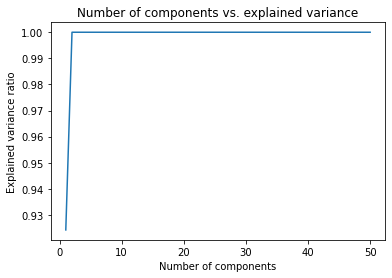

In [28]:
def P1():
    
    k = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    pca = PCA(n_components=k[-1])
    pca.fit(test_data.fillna(0))
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    print("Percentage of variance explained by each of the first k components:")
    for i, k in enumerate(k):
        print(f'k = {k}: {round(explained_variance[k-1], 2)}')
        
    plt.plot(np.arange(1,51), explained_variance)
    plt.ylabel('Explained variance ratio') 
    plt.xlabel('Number of components')
    plt.title('Number of components vs. explained variance')  
    plt.show() 

P1()

## Regression Models

In [29]:
train_data.isna().any()

views                       False
likes                       False
dislikes                    False
comments                    False
budget                      False
                            ...  
Turkey                       True
Ukraine                      True
United Arab Emirates         True
United Kingdom               True
United States of America     True
Length: 164, dtype: bool

In [30]:
train_data = train_data.fillna(0)
val_data = val_data.fillna(0)
test_data = test_data.fillna(0)

### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Fitting Linear Model for Rating
linear_model = LinearRegression().fit(train_data, train_rating_labels)
dev_predicted_rating_labels = linear_model.predict(val_data)
accuracy = linear_model.score(val_data, val_rating_labels)
print('Linear Regression Ratings Accuracy: ', accuracy)

# Collecting Other Metrics for Ratings
mse_ratings = mean_squared_error(val_rating_labels, dev_predicted_rating_labels)
mae_ratings = mean_absolute_error(val_rating_labels, dev_predicted_rating_labels)
print('Linear Regression Ratings Mean Squared Error: ', mse_ratings)
print('Linear Regression Ratings Mean Absolute Error: ', mae_ratings)
print()

# Fitting Linear Model for Popularity
linear_model = LinearRegression().fit(train_data, train_popularity_labels)
dev_predicted_popularity_labels = linear_model.predict(val_data)
accuracy = linear_model.score(val_data, val_popularity_labels)
print('Linear Regression Popularity Accuracy: ', accuracy)

# Collecting Other Metrics for Popularity
mse_popularity = mean_squared_error(val_popularity_labels, dev_predicted_popularity_labels)
mae_popularity = mean_absolute_error(val_popularity_labels, dev_predicted_popularity_labels)
print('Linear Regression Popularity Mean Squared Error: ', mse_popularity)
print('Linear Regression Popularity Mean Absolute Error: ', mae_popularity)

Linear Regression Ratings Accuracy:  -0.08237022717990139
Linear Regression Ratings Mean Squared Error:  0.9194869423564762
Linear Regression Ratings Mean Absolute Error:  0.757655371531562

Linear Regression Popularity Accuracy:  -0.15877354867409044
Linear Regression Popularity Mean Squared Error:  308.63515593720064
Linear Regression Popularity Mean Absolute Error:  11.685471250093856


### Random Forest Regression

In [32]:
# Random forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Fitting Random Forest Regressor for Ratings
rand_forest_model = RandomForestRegressor().fit(train_data, train_rating_labels)
dev_predicted_labels = rand_forest_model.predict(val_data)
accuracy = rand_forest_model.score(val_data, val_rating_labels)
print('Random Forest Regressor Popularity Accuracy: ', accuracy)

# Collecting Other Metrics for Ratings
mse_ratings = mean_squared_error(val_rating_labels, dev_predicted_labels)
mae_ratings = mean_absolute_error(val_rating_labels, dev_predicted_labels)
print('Random Forest Regressor Ratings Mean Squared Error: ', mse_ratings)
print('Random Forest Regressor Ratings Mean Absolute Error: ', mae_ratings)
print()

# Fitting Random Forest Regressor for Popularity
rand_forest_model = RandomForestRegressor().fit(train_data, train_popularity_labels)
dev_predicted_labels = rand_forest_model.predict(val_data)
accuracy = rand_forest_model.score(val_data, val_popularity_labels)
print('Randrom Forest Regressor Popularity Accuracy: ', accuracy)

# Collecting Other Metrics for Popularity
mse_popularity = mean_squared_error(val_popularity_labels, dev_predicted_labels)
mae_popularity = mean_absolute_error(val_popularity_labels, dev_predicted_labels)
print('Random Forest Regressor Popularity Mean Squared Error: ', mse_popularity)
print('Random Forest Regressor Popularity Mean Absolute Error: ', mae_popularity)

Random Forest Regressor Popularity Accuracy:  -0.05410874218190731
Random Forest Regressor Ratings Mean Squared Error:  0.8954784600694445
Random Forest Regressor Ratings Mean Absolute Error:  0.742671875

Randrom Forest Regressor Popularity Accuracy:  -0.24283732481298093
Random Forest Regressor Popularity Mean Squared Error:  331.0252395622399
Random Forest Regressor Popularity Mean Absolute Error:  13.773902479270832


### Stochastic Gradient Descent Regression

In [33]:
# Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Fitting Stochastic Gradient Descent Regression for Ratings
sgd_model = SGDRegressor().fit(train_data, train_rating_labels)
dev_predicted_labels = sgd_model.predict(val_data)
accuracy = sgd_model.score(val_data, val_rating_labels)
print('Stochastic Gradient Descent Regression Accuracy: ', accuracy)

# Collecting Other Metrics for Ratings
mse_ratings = mean_squared_error(val_rating_labels, dev_predicted_labels)
mae_ratings = mean_absolute_error(val_rating_labels, dev_predicted_labels)
print('Stochastic Gradient Descent Regression  Mean Squared Error: ', mse_ratings)
print('Stochastic Gradient Descent Regression  Mean Absolute Error: ', mae_ratings)
print()

# Fitting Stochastic Gradient Descent Regression for Popularity
sgd_model = SGDRegressor().fit(train_data, train_popularity_labels)
dev_predicted_labels = sgd_model.predict(val_data)
accuracy = sgd_model.score(val_data, val_popularity_labels)
print('Stochastic Gradient Descent Regression Accuracy: ', accuracy)

# Collecting Other Metrics for Popularity
mse_popularity = mean_squared_error(val_popularity_labels, dev_predicted_labels)
mae_popularity = mean_absolute_error(val_popularity_labels, dev_predicted_labels)
print('Random Forest Regressor Popularity Mean Squared Error: ', mse_popularity)
print('Random Forest Regressor Popularity Mean Absolute Error: ', mae_popularity)

Stochastic Gradient Descent Regression Accuracy:  -1.9110561869820242e+46
Stochastic Gradient Descent Regression  Mean Squared Error:  1.623465950849241e+46
Stochastic Gradient Descent Regression  Mean Absolute Error:  6.322127256729647e+22

Stochastic Gradient Descent Regression Accuracy:  -1.5379670215987822e+45
Random Forest Regressor Popularity Mean Squared Error:  4.0963197000876235e+47
Random Forest Regressor Popularity Mean Absolute Error:  4.720176310007103e+23
